In [1]:
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow import keras
import pandas as pd
import numpy as np
import sklearn
import os
import shutil

from pathlib import Path
from IPython.display import display, Audio


In [2]:
'''
We have the following directory structure:

\train_audio
    \aldfly   \
    \ameavo    |
    .          | folder names are bird species (categorical lables)
    .          | we have 264 species in the dataset
    .          |
    \yetvir   /

for each species we have a number of .mp3 samples 
'''
''

''

In [3]:
'''
rootdir = 'train_audio'

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        print(subdir+'/'+file)'''

"\nrootdir = 'train_audio'\n\nfor subdir, dirs, files in os.walk(rootdir):\n    for file in files:\n        print(subdir+'/'+file)"

In [4]:
index = pd.read_csv('train.csv')

In [5]:
index['filename'] = ('train_audio/'+index['ebird_code']+'/'+index['filename'])

In [6]:
index['filename']=index['filename'].apply(lambda x: x.replace('mp3','wav'))
index['channels']=1

In [7]:
index.head()

,rating,playback_used,ebird_code,channels,date,pitch,duration,filename,speed,species,...,xc_id,url,country,author,primary_label,longitude,length,time,recordist,license
0,3.5,no,aldfly,1,2013-05-25,Not specified,25,train_audio/aldfly/XC134874.wav,Not specified,Alder Flycatcher,...,134874,https://www.xeno-canto.org/134874,United States,Jonathon Jongsma,Empidonax alnorum_Alder Flycatcher,-92.962,Not specified,8:00,Jonathon Jongsma,Creative Commons Attribution-ShareAlike 3.0
1,4.0,no,aldfly,1,2013-05-27,both,36,train_audio/aldfly/XC135454.wav,both,Alder Flycatcher,...,135454,https://www.xeno-canto.org/135454,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,0-3(s),08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...
2,4.0,no,aldfly,1,2013-05-27,both,39,train_audio/aldfly/XC135455.wav,both,Alder Flycatcher,...,135455,https://www.xeno-canto.org/135455,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,0-3(s),08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...
3,3.5,no,aldfly,1,2013-05-27,both,33,train_audio/aldfly/XC135456.wav,both,Alder Flycatcher,...,135456,https://www.xeno-canto.org/135456,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,0-3(s),08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...
4,4.0,no,aldfly,1,2013-05-27,both,36,train_audio/aldfly/XC135457.wav,level,Alder Flycatcher,...,135457,https://www.xeno-canto.org/135457,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,0-3(s),08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...


In [8]:
index=index.drop([14931,9703,14933,3755,3756,8024,18884, 160,   476,   536,   927,   933,  1641,  2637,  2797,  4735,
             5062,  6247,  6646,  8215,  9247,  9590, 11154, 11642, 11681,
            12372, 12647, 13610, 13789, 13792, 15859, 16406, 17234, 17663,
            17664, 17665, 20706, 20883],axis=0)

In [9]:
index.columns

Index(['rating', 'playback_used', 'ebird_code', 'channels', 'date', 'pitch',
       'duration', 'filename', 'speed', 'species', 'number_of_notes', 'title',
       'secondary_labels', 'bird_seen', 'sci_name', 'location', 'latitude',
       'sampling_rate', 'type', 'elevation', 'description', 'bitrate_of_mp3',
       'file_type', 'volume', 'background', 'xc_id', 'url', 'country',
       'author', 'primary_label', 'longitude', 'length', 'time', 'recordist',
       'license'],
      dtype='object')

<AxesSubplot:ylabel='Frequency'>

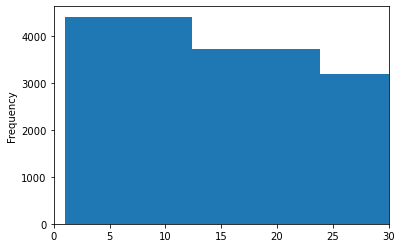

In [10]:
index['duration'].plot(kind='hist',bins=200, xlim=(0,30))

In [11]:
audio = tfio.audio.AudioIOTensor(
    "train_audio/amebit/XC310046.wav", dtype=None
)

In [12]:
audio

<AudioIOTensor: shape=[7296    1], dtype=<dtype: 'int16'>, rate=16000>

In [13]:
audio_slice = audio[0:]

# remove last dimension
audio_tensor = tf.squeeze(audio_slice, axis=[-1])

print(audio_tensor)

tf.Tensor([0 0 0 ... 0 0 0], shape=(7296,), dtype=int16)


In [14]:
Audio(audio_tensor.numpy(), rate=audio.rate.numpy())

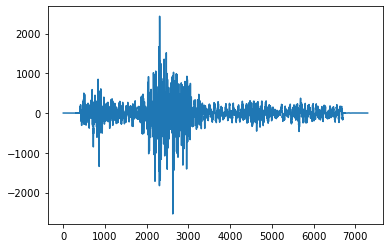

In [15]:
import matplotlib.pyplot as plt


tensor = tf.cast(audio_tensor, tf.float32)

plt.figure()
plt.plot(tensor.numpy())

In [16]:
tensor.numpy()

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

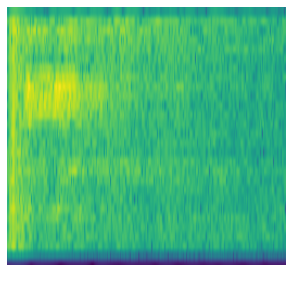

In [17]:
# Convert to spectrogram
spectrogram = tfio.experimental.audio.spectrogram(
    tensor, nfft=512, window=512, stride=256)

fig,ax = plt.subplots(figsize=(5,5))
ax.imshow(tf.math.log(spectrogram).numpy(),aspect='auto')
ax.set_axis_off()
#plt.savefig('train_audio/aldfly/XC134874.png')

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(index['filename'], index['ebird_code'], test_size=0.33)

In [19]:
index['filename'][0][:-3]

'train_audio/aldfly/XC134874.'

In [20]:
def toTensor(row):
    try:
        return tfio.audio.AudioIOTensor(row, dtype=None).to_tensor()
    except:
        return np.nan

In [21]:

''' Converts original mono and stereo mp3 files to mono wav files

from pydub import AudioSegment
j=0
dropped = []
for i in index['filename']:
    try:
        j+=1
        print(i, (100*j)/21375,'% done')
        sound = AudioSegment.from_mp3(i)
        sound = sound.set_channels(1)
        sound = sound.set_frame_rate(16000)
        sound.export(i[:-3]+'wav', format="wav")
        os.remove(i)
    except:
        dropped.append(i)
        os.remove(i)
'''

' Converts original mono and stereo mp3 files to mono wav files\n\nfrom pydub import AudioSegment\nj=0\ndropped = []\nfor i in index[\'filename\']:\n    try:\n        j+=1\n        print(i, (100*j)/21375,\'% done\')\n        sound = AudioSegment.from_mp3(i)\n        sound = sound.set_channels(1)\n        sound = sound.set_frame_rate(16000)\n        sound.export(i[:-3]+\'wav\', format="wav")\n        os.remove(i)\n    except:\n        dropped.append(i)\n        os.remove(i)\n'

In [32]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In [24]:
tf.executing_eagerly()

True

In [25]:
tf.__version__

'2.4.1'

In [26]:
DATASET_AUDIO_PATH = 'train_audio'

# Percentage of samples to use for validation
VALID_SPLIT = 0.1

# Seed to use when shuffling the dataset and the noise
SHUFFLE_SEED = 43

# The sampling rate to use.
# This is the one used in all of the audio samples.
# We will resample all of the noise to this sampling rate.
# This will also be the output size of the audio wave samples
# (since all samples are of 1 second long)
SAMPLING_RATE = 16000

# The factor to multiply the noise with according to:
#   noisy_sample = sample + noise * prop * scale
#      where prop = sample_amplitude / noise_amplitude
SCALE = 0.5

BATCH_SIZE = 128
EPOCHS = 100

def paths_and_labels_to_dataset(audio_paths, labels):
    """Constructs a dataset of audios and labels."""
    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
    audio_ds = path_ds.map(lambda x: path_to_audio(x))
    #audio_ds = tfio.audio.AudioIODataset.from_tensor_slices(audio_paths)
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    return tf.data.Dataset.zip((audio_ds, label_ds))

def path_to_audio(path):
    """Reads and decodes an audio file."""
    audio = tf.io.read_file(path)
    audio, _ = tf.audio.decode_wav(audio, 1, SAMPLING_RATE*15)
    return audio


def add_noise(audio, noises=None, scale=0.5):
    if noises is not None:
        # Create a random tensor of the same size as audio ranging from
        # 0 to the number of noise stream samples that we have.
        tf_rnd = tf.random.uniform(
            (tf.shape(audio)[0],), 0, noises.shape[0], dtype=tf.int32
        )
        noise = tf.gather(noises, tf_rnd, axis=0)

        # Get the amplitude proportion between the audio and the noise
        prop = tf.math.reduce_max(audio, axis=1) / tf.math.reduce_max(noise, axis=1)
        prop = tf.repeat(tf.expand_dims(prop, axis=1), tf.shape(audio)[1], axis=1)

        # Adding the rescaled noise to audio
        audio = audio + noise * prop * scale

    return audio


def audio_to_fft(audio):
    # Since tf.signal.fft applies FFT on the innermost dimension,
    # we need to squeeze the dimensions and then expand them again
    # after FFT
    audio = tf.squeeze(audio, axis=-1)
    fft = tf.signal.fft(
        tf.cast(tf.complex(real=audio, imag=tf.zeros_like(audio)), tf.complex64)
    )
    fft = tf.expand_dims(fft, axis=-1)

    # Return the absolute value of the first half of the FFT
    # which represents the positive frequencies
    return tf.math.abs(fft[:, : (audio.shape[1] // 2), :])


# Get the list of audio file paths along with their corresponding labels

class_names = os.listdir(DATASET_AUDIO_PATH)
class_names.remove('.DS_Store')
print("Our class names: {}".format(class_names,))

audio_paths = []
labels = []
for label, name in enumerate(class_names):
    print("Processing bird {}".format(name,))
    dir_path = Path(DATASET_AUDIO_PATH) / name
    speaker_sample_paths = [
        os.path.join(dir_path, filepath)
        for filepath in os.listdir(dir_path)
        if filepath.endswith(".wav")
    ]
    audio_paths += speaker_sample_paths
    labels += [label] * len(speaker_sample_paths)

print(
    "Found {} files belonging to {} classes.".format(len(audio_paths), len(class_names))
)

# Shuffle
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(audio_paths)
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(labels)

# Split into training and validation
num_val_samples = int(VALID_SPLIT * len(audio_paths))
print("Using {} files for training.".format(len(audio_paths) - num_val_samples))
train_audio_paths = audio_paths[:-num_val_samples]
train_labels = labels[:-num_val_samples]

print("Using {} files for validation.".format(num_val_samples))
valid_audio_paths = audio_paths[-num_val_samples:]
valid_labels = labels[-num_val_samples:]

# Create 2 datasets, one for training and the other for validation
train_ds = paths_and_labels_to_dataset(train_audio_paths, train_labels)
train_ds = train_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
    BATCH_SIZE
)

valid_ds = paths_and_labels_to_dataset(valid_audio_paths, valid_labels)
valid_ds = valid_ds.shuffle(buffer_size=32 * 8, seed=SHUFFLE_SEED).batch(32)


# Transform audio wave to the frequency domain using `audio_to_fft`
train_ds = train_ds.map(
    lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.experimental.AUTOTUNE
)
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)

valid_ds = valid_ds.map(
    lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.experimental.AUTOTUNE
)
valid_ds = valid_ds.prefetch(tf.data.experimental.AUTOTUNE)

Our class names: ['olsfly', 'houspa', 'semplo', 'evegro', 'brnthr', 'truswa', 'brespa', 'gryfly', 'canwre', 'belkin1', 'bkhgro', 'sagthr', 'comrav', 'bnhcow', 'rufhum', 'blujay', 'ribgul', 'cliswa', 'carwre', 'comgol', 'daejun', 'pygnut', 'btywar', 'gadwal', 'calgul', 'bongul', 'rebwoo', 'caster1', 'mouchi', 'horgre', 'hoomer', 'pinsis', 'banswa', 'whtswi', 'annhum', 'rebnut', 'comgra', 'amerob', 'brebla', 'blugrb1', 'magwar', 'merlin', 'rocpig', 'reevir1', 'westan', 'amered', 'norcar', 'nrwswa', 'grycat', 'reshaw', 'semsan', 'gnwtea', 'rufgro', 'bewwre', 'greegr', 'whcspa', 'barswa', 'bkbwar', 'sora', 'macwar', 'chiswi', 'easblu', 'norpin', 'scoori', 'sonspa', 'greroa', 'y00475', 'amepip', 'bulori', 'gockin', 'buwwar', 'spotow', 'lotduc', 'gcrfin', 'boboli', 'rthhum', 'amekes', 'wooscj2', 'chukar', 'yehbla', 'chispa', 'bktspa', 'balori', 'juntit1', 'canwar', 'labwoo', 'bawwar', 'yelwar', 'rudduc', 'linspa', 'whtspa', 'casvir', 'comnig', 'eursta', 'prawar', 'warvir', 'lesyel', 'grtgra'

In [41]:
def residual_block(x, filters, conv_num=3, activation="relu", pool_size=2, strides=2):
    # Shortcut
    s = keras.layers.Conv1D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
        x = keras.layers.Conv1D(filters, 3, padding="same")(x)
        x = keras.layers.Activation(activation)(x)
    x = keras.layers.Conv1D(filters, 3, padding="same")(x)
    x = keras.layers.Add()([x, s])
    x = keras.layers.Activation(activation)(x)
    return keras.layers.MaxPool1D(pool_size=pool_size, strides=strides)(x)


def build_model(input_shape, num_classes):
    inputs = keras.layers.Input(shape=input_shape, name="input")

    x = residual_block(inputs, 16, 2)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 128, 3, 'relu',3,3)
    x = residual_block(x, 128, 3, 'relu',3,3)

    x = keras.layers.AveragePooling1D(pool_size=3, strides=3)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(128, activation="relu")(x)
    x = keras.layers.Dense(64, activation="relu")(x)

    outputs = keras.layers.Dense(num_classes, activation="softmax", name="output")(x)

    return keras.models.Model(inputs=inputs, outputs=outputs)


model = build_model((SAMPLING_RATE*15 // 2, 1), len(class_names))

model.summary()

# Compile the model using Adam's default learning rate
model.compile(
    optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# Add callbacks:
# 'EarlyStopping' to stop training when the model is not enhancing anymore
# 'ModelCheckPoint' to always keep the model that has the best val_accuracy
model_save_filename = "model.h5"

earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
mdlcheckpoint_cb = keras.callbacks.ModelCheckpoint(
    model_save_filename, monitor="val_accuracy", save_best_only=True)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 120000, 1)]  0                                            
__________________________________________________________________________________________________
conv1d_103 (Conv1D)             (None, 120000, 16)   64          input[0][0]                      
__________________________________________________________________________________________________
activation_47 (Activation)      (None, 120000, 16)   0           conv1d_103[0][0]                 
__________________________________________________________________________________________________
conv1d_104 (Conv1D)             (None, 120000, 16)   784         activation_47[0][0]              
____________________________________________________________________________________________

In [34]:
np.random.seed(42)
tf.random.set_seed(42)

model2 = keras.models.Sequential()
model2.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model2.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model2.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model2.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, None, 20)          60        
_________________________________________________________________
conv1d_46 (Conv1D)           (None, None, 20)          820       
_________________________________________________________________
conv1d_47 (Conv1D)           (None, None, 20)          820       
_________________________________________________________________
conv1d_48 (Conv1D)           (None, None, 20)          820       
_________________________________________________________________
conv1d_49 (Conv1D)           (None, None, 20)          820       
_________________________________________________________________
conv1d_50 (Conv1D)           (None, None, 20)          820       
_________________________________________________________________
conv1d_51 (Conv1D)           (None, None, 20)         

In [28]:
import pydot

In [36]:
#keras.utils.plot_model(model2)

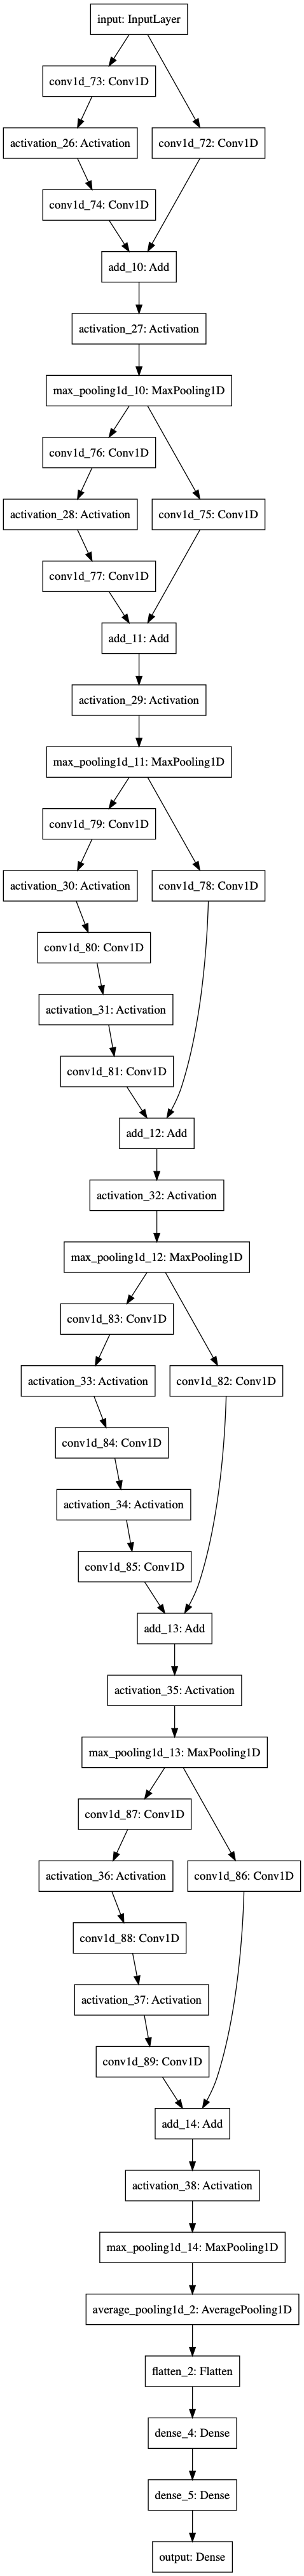

In [39]:
keras.utils.plot_model(model)

In [ ]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=valid_ds,
    callbacks=[earlystopping_cb, mdlcheckpoint_cb],
)

Epoch 1/100
  1/151 [..............................] - ETA: 15:34:30 - loss: 5.8691 - accuracy: 0.0000e+00